In [6]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import datetime

import sklearn as sk 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import json

## Ingestion and Initial Clean

In [7]:
json_f = open("ingestion.json", "r")
json_f = json.loads(json_f.read())
rename_dd = json_f['Rename']
details_dd = json_f["Details"]

# for k,v in rename_dd.items():
#     print('"' + v + '"' + ":  {")
#     print('\t"description": ,')
#     print('\t"class": ,')
#     print('\t"origin": ')
#     print("},")
#     print()

In [8]:
check_audio_feature_count = 29503
check_chart_count = 327895

In [9]:
charts_df = pd.read_csv('../data/hot_100_charts.csv')
if len(charts_df) != check_chart_count:
    raise("Error, unexpected row count for Chart")

audio_feature_df = pd.read_excel('../data/hot_100_audio_features.xlsx')
if len(audio_feature_df) != check_audio_feature_count:
    raise("Error, unexpected row count for Audio Feature")

In [10]:
# DROP audio feature entries that are absent of audio features
audio_feature_df = audio_feature_df.loc[~(audio_feature_df['spotify_track_id'].isna()) & 
                                        ~(audio_feature_df['liveness'].isna()) & 
                                        ~(audio_feature_df['spotify_track_popularity'].isna())]

In [11]:
# CONFIRM datetime for charts
charts_df['WeekID'] = pd.to_datetime(charts_df['WeekID'], errors='coerce')

In [12]:
# Clean charts to find peak week of each song 
# (assuming that the peak week indicates era of highest popularity)
weeks_df = charts_df.loc[charts_df['Week Position'] == charts_df['Peak Position']]

# order by highest position, then drop all other instances of non-peak
weeks_df = weeks_df.sort_values(by = ['Peak Position', 'SongID', 'Weeks on Chart'], ascending = [True, True, False])

weeks_df = weeks_df.drop_duplicates(subset=['SongID']) 

In [13]:
print("Length of audio features:", len(audio_feature_df))
print("Length of Hot 100 Billboard:", len(weeks_df))

Length of audio features: 24330
Length of Hot 100 Billboard: 29386


In [14]:
# join dfs
combined_df = pd.merge(weeks_df, audio_feature_df, on = ['SongID', 'Song', 'Performer'], how = 'inner')
print(len(combined_df))

# rename
combined_df = combined_df.rename(columns = rename_dd)

24281


In [15]:
combined_df.to_csv("../data/ingested.csv")

## Visualizations and Summary Stats

In [16]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (18, 9)

font = {'family': 'sans-serif', 
        'style': 'normal', 
        'weight': 'bold', 
        'size': 10}
plt.rc('font', **font)

spot_green = "#1db954"
spot_white = "#ffffff"
spot_black = "#191414"

In [17]:
# re-used columns for easy access
quant_columns = [k for k, v in details_dd.items() if (v['class'] == 'Quant' or k == "Explicit")]
cat_columns = [k for k, v in details_dd.items() if v['class'] == 'Cat']

#### Summary Statistics

In [18]:
# FIXME: is SexualGoddess an error (it's marked as 51 minutes long)
# UPDATE: it is indeed incorrect, it's only 181000 long

# FIXME: Instrumentalness 0.8 in mid 90s
# UPDATE: only one song peaked in on 1991-01-26, and it has an instrumentalness of 0.764
# UPDATE: it doesn't sound super instrumental, will need to check with true API call

upper_date = datetime.strptime('1991-02-01', '%Y-%m-%d')
lower_date = datetime.strptime('1991-01-20', '%Y-%m-%d')
spec_date = datetime.strptime('1991-01-26', '%Y-%m-%d')

ts_df = combined_df.loc[(combined_df["WeekID"] < upper_date) & (combined_df["WeekID"] > lower_date)]
# ts_df = combined_df.loc[(combined_df["WeekID"] == spec_date)]
display(ts_df[['WeekID', 'Instrumentalness', 'SongID', 'Peak Position']])

combined_df = combined_df.loc[combined_df['SongID'] != "SexualGoddess"]

,WeekID,Instrumentalness,SongID,Peak Position
23629,1991-01-26,0.764,Close To MeThe Cure,97


In [19]:
print(len(combined_df))

24280


In [22]:
summary_stats = combined_df[quant_columns].describe()
display(summary_stats)
summary_stats.to_csv('../data/summary_stats.csv')

,Week Positon,Instance,Previous Week Position,Peak Position,Weeks on Chart,Duration (ms),Explicit,Danceability,Energy,Loudness (db),Acousticness,Speechiness,Instrumentalness,Liveness,Valence,Tempo,Popularity
count,24280.000000,24280.000000,20649.000000,24280.000000,24280.000000,2.428000e+04,24280.000000,24280.000000,24280.000000,24280.000000,24280.000000,24280.000000,24280.000000,24280.000000,24280.000000,24280.000000,24280.000000
mean,44.501812,1.057867,43.401811,44.501812,7.248105,2.205277e+05,0.119605,0.599776,0.618115,-8.665139,0.294850,0.073497,0.032544,0.192191,0.601845,120.272666,41.208896
std,30.343444,0.319196,29.995208,30.343444,5.028742,6.524786e+04,0.324505,0.153157,0.199116,3.602613,0.282343,0.083067,0.136300,0.159146,0.238627,28.042603,22.468947
min,1.000000,1.000000,1.000000,1.000000,1.000000,2.968800e+04,0.000000,0.000000,0.000581,-28.030000,0.000003,0.000000,0.000000,0.009670,0.000000,0.000000,0.000000
25%,16.000000,1.000000,15.000000,16.000000,3.000000,1.749965e+05,0.000000,0.499000,0.476000,-11.035250,0.046800,0.032100,0.000000,0.090900,0.415000,99.062250,23.000000
50%,43.000000,1.000000,41.000000,43.000000,7.000000,2.148260e+05,0.000000,0.608000,0.634000,-8.205000,0.195000,0.041300,0.000005,0.131000,0.622000,118.917000,43.000000
75%,71.000000,1.000000,69.000000,71.000000,10.000000,2.532000e+05,0.000000,0.708000,0.778000,-5.856000,0.508000,0.068200,0.000458,0.249000,0.802000,136.483250,59.000000
max,100.000000,10.000000,100.000000,100.000000,56.000000,1.561133e+06,1.000000,0.988000,0.997000,2.291000,0.991000,0.951000,0.982000,0.999000,0.991000,241.009000,100.000000


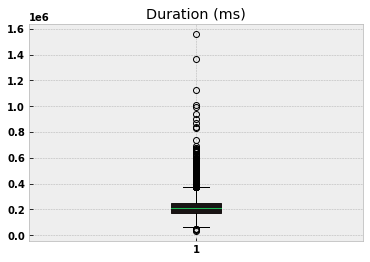

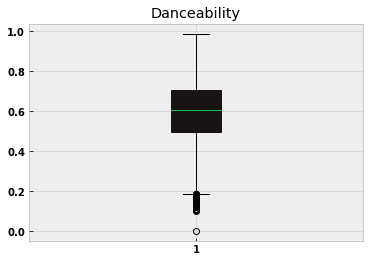

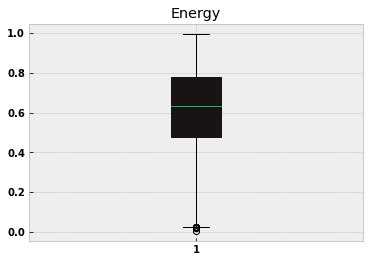

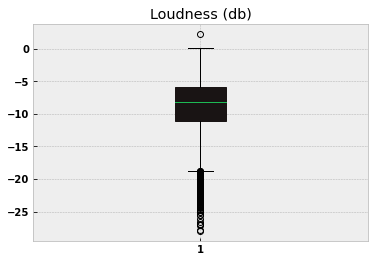

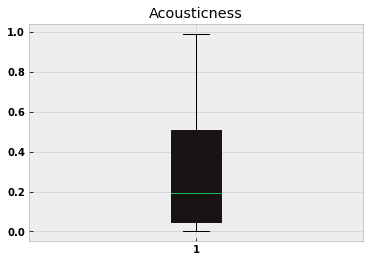

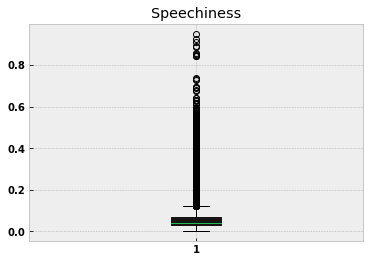

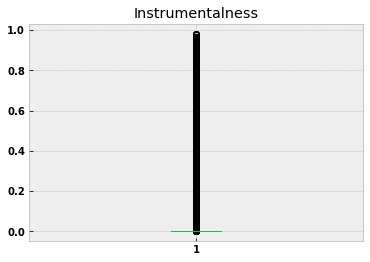

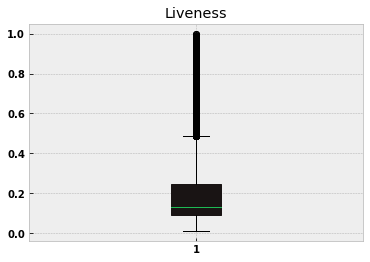

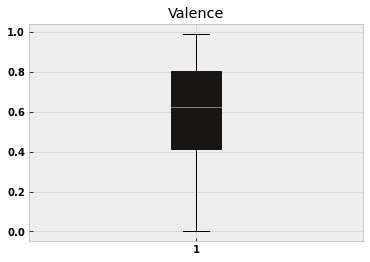

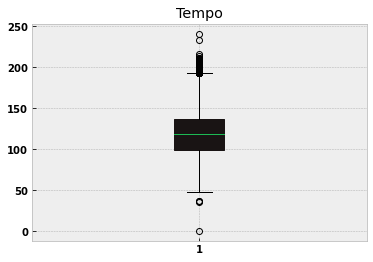

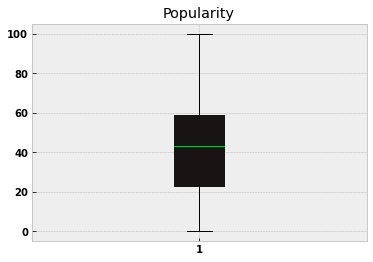

In [23]:
boxplot_file = open('../data/boxplot.txt', 'w')

for column in details_dd:
    if (details_dd[column]["class"] == "Quant" and details_dd[column]['origin'] == "spotify"):
        box1 = plt.boxplot(combined_df[column], patch_artist=True)
        plt.setp(box1['boxes'], color=spot_black)
        plt.setp(box1['medians'], color = spot_green)
        plt.setp(box1['boxes'], facecolor = spot_black)
        plt.title(column)
        plt.savefig('../images/boxplots/'+column+'_boxplot.eps', format = 'eps')
        plt.show()

        boxplot_file.write('\\begin{figure} [h!]\n')
        boxplot_file.write('\t\\includegraphics[width = \\linewidth]{boxplots/' + column + '_boxplot.eps}\n')
        boxplot_file.write('\t\\caption{Analysis of ' + column + ' distributions of the tracks in the Billboard Hot 100 charts. See the data dictionary section for a more detailed description of this feature.}\n')
        boxplot_file.write('\t\\label{fig:' + column + '_boxplot}\n')
        boxplot_file.write('\\end{figure}\n\n')

boxplot_file.close()

#### Entries per week

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


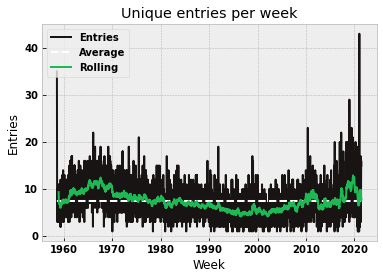

In [24]:
# see amount of entries per week
# count stores in other columns for whatever reason
# (previous week position less because some previous weeks are NaN)
dates_df = combined_df.groupby(by='WeekID', as_index=False).count()

x = np.array(dates_df['WeekID'])
y = np.array(dates_df['hot_100_url'])
avg = np.repeat(dates_df['hot_100_url'].mean(), len(x))
rolling = dates_df['hot_100_url'].rolling(window=20).mean()

plt.plot(x,y, label='Entries', color = spot_black)
plt.plot(x, avg, '--', label='Average', color = spot_white)
plt.plot(x, rolling, label="Rolling", color = spot_green)
plt.title('Unique entries per week')
plt.xlabel('Week')
plt.ylabel('Entries')
plt.legend(loc='upper left')
plt.savefig('../images/time_series/entries_per_week_ts.eps', format = 'eps')
plt.show()

# It's expected that the first and last entries have the most because that's when they would peak

In [25]:
print(f"Unique weeks: {len(x)}")
print(f"Average entries per week: {dates_df['hot_100_url'].mean()}")
print(f"Standard deviation per week: {np.std(dates_df['hot_100_url'])}")

Unique weeks: 3252
Average entries per week: 7.466174661746617
Standard deviation per week: 3.5564019511132257


#### Average feature per week

In [26]:
# average stats over a given week
upper_date = datetime.strptime('1991-03-01', '%Y-%m-%d')
lower_date = datetime.strptime('1991-01-01', '%Y-%m-%d')

quant_columns = []
for column in details_dd:
    if (details_dd[column]["class"] == "Quant" and details_dd[column]['origin'] == "spotify") or column == "Explicit":
        quant_columns.append(column)

avg_weeks_df = combined_df.groupby('WeekID', as_index = False)[quant_columns].mean()
# avg_weeks_df = avg_weeks_df.loc[(avg_weeks_df["WeekID"] < upper_date) & (avg_weeks_df["WeekID"] > lower_date)]
# display(avg_weeks_df)

In [27]:
print('\\begin{figure} [h!]')

\begin{figure} [h!]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


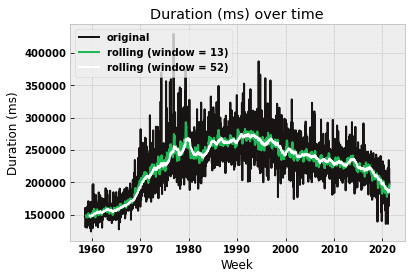

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


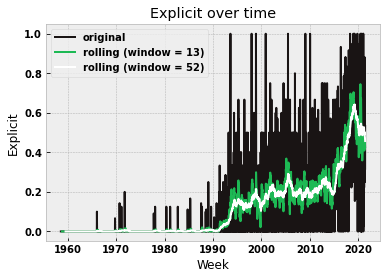

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


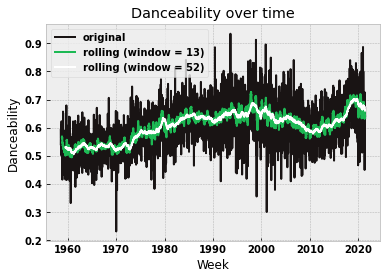

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


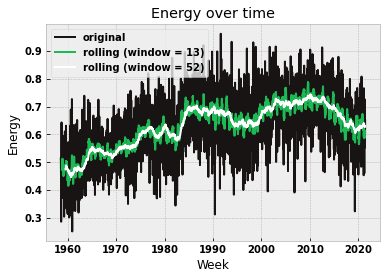

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


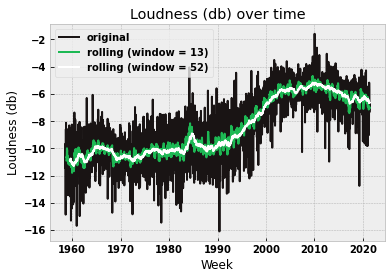

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


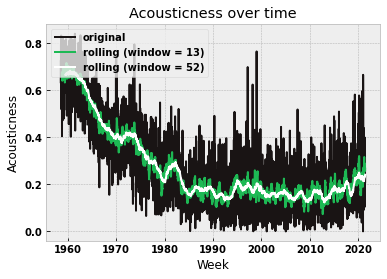

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


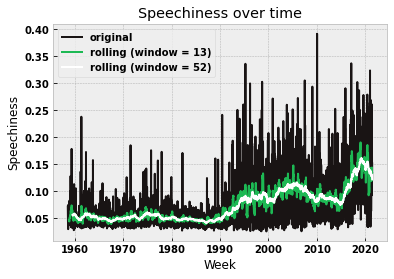

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


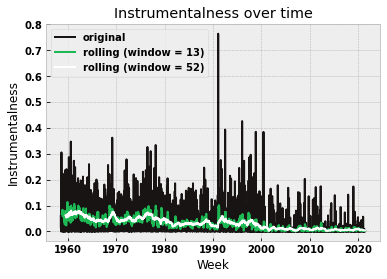

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


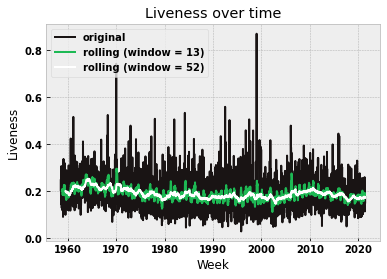

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


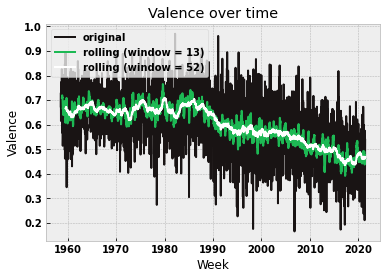

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


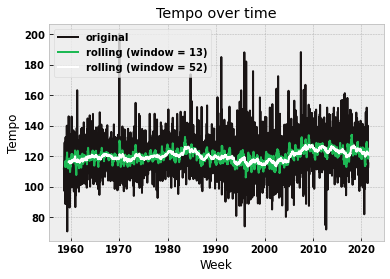

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


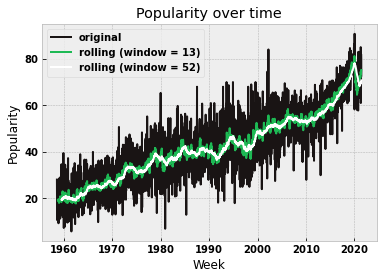

In [28]:
ts_file = open("../data/ts.txt", "w")

x = np.array(avg_weeks_df['WeekID'])
window_size = 13
for column in details_dd:
    if (details_dd[column]["class"] == "Quant" and details_dd[column]["origin"] == 'spotify') or column == "Explicit": 
        y = np.array(avg_weeks_df[column])
        rolling = avg_weeks_df[column].rolling(window=window_size).mean()
        rolling2 = avg_weeks_df[column].rolling(window=int(window_size*4)).mean()
        plt.plot(x,y, label = 'original', color = spot_black)
        plt.plot(x, rolling, label = f'rolling (window = {window_size})', color = spot_green)
        plt.plot(x, rolling2, label = f'rolling (window = {int(window_size*4)})', color = spot_white)
        plt.title(f"{column} over time")
        plt.xlabel('Week')
        plt.ylabel(f"{column}")
        plt.legend(loc = 'upper left')
        plt.savefig('../images/time_series/'+column+'_ts.eps', format = 'eps')
        plt.show()

        ts_file.write('\\begin{figure} [h!]\n')
        ts_file.write('\t\\includegraphics[width = \\linewidth]{ts/' + column + '_ts.eps}\n')
        ts_file.write('\t\\caption{Analysis of ' + column + ' averages of the tracks that peaked on the Hot 100 Billboard Chart during a given week. See the data dictionary section for a more detailed description of this feature.}\n')
        ts_file.write('\t\\label{fig:' + column + '_ts}\n')
        ts_file.write('\\end{figure}\n\n')

ts_file.close()

#### Linear Regression

In [29]:
# use linear regression to try and predict date, look at co-effs
# FIXME not valid for a time series analysis

x = combined_df[quant_columns[:-1]] # everything but popularity
y = combined_df['WeekID']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.7)

lr = LinearRegression(fit_intercept=False)

lr.fit(x_train, y_train)

coeffs_df = pd.DataFrame({'Column':quant_columns[:-1], 'Coefficient' : lr.coef_})

display(coeffs_df)

,Column,Coefficient
0,Duration (ms),1.476440e+12
1,Explicit,3.136177e+17
2,Danceability,1.175966e+18
3,Energy,3.958731e+17
4,Loudness (db),4.070112e+16
5,Acousticness,-2.753430e+17
6,Speechiness,4.080001e+17
7,Instrumentalness,-3.219376e+17
8,Liveness,-1.198071e+17
9,Valence,-1.004796e+18
